# Knotch Data Exploration Assignment

### Leland Barnard
### 8 May 2017

## Preliminaries
### In this section, I'll prepare the notebook and take a look at the data.  The actual analysis will begin in Section 1.

In [47]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
%load_ext sql

/opt/conda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


I'll first load the csv into a pandas DataFrame and take a look at the size of the data set and the numbers of missing values for each column.




In [3]:
knotch_df = pd.read_csv('knotch_ds_takehome.csv',encoding='utf-8')

In [5]:
knotch_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5870299 entries, 0 to 5870298
Data columns (total 13 columns):
user_id             object
survey_id           object
view_id             object
ts                  object
city                object
country             object
device              object
os                  object
browser             object
time_on_page        float64
time_to_interact    float64
interaction_type    object
response            float64
dtypes: float64(3), object(10)
memory usage: 5.9 GB


In [7]:
knotch_df.isnull().sum()

user_id                   0
survey_id                 0
view_id                   0
ts                        0
city                1214396
country                2214
device                 9623
os                    20280
browser               43441
time_on_page        3693095
time_to_interact    5779974
interaction_type    5779974
response            5853622
dtype: int64

I also want to take a look at the data, so I'll sample 5 observations at random.

In [8]:
knotch_df.sample(5)

,user_id,survey_id,view_id,ts,city,country,device,os,browser,time_on_page,time_to_interact,interaction_type,response
5127654,5832cdb856349f033bc00fc6,580f8ed8bbe4ee292d370280,5832cdca92855778471c2b52,2016-11-21 10:34:50.154,Union City,US,desktop,Windows,Firefox,3.605,NaN,NaN,NaN
507497,576e5b4b8c915d641815a8b1,576c689af2d255082991e74f,5772320ffcbc952529c2b2a0,2016-06-28 08:15:11.045,Florianópolis,BR,desktop,Windows,Chrome,301.194,NaN,NaN,NaN
5757771,58d1c9d8df6d43ef73e8a565,58c9b16164b20c43664c8f3e,58d1c9d8b364c93938f8db69,2017-03-22 00:48:24.448,Edgewater,US,tablet,iOS,Facebook,NaN,NaN,NaN,NaN
1235593,57883a536b8b9ce53756ec80,577ce28db0e2da617de1bb95,57883a53d6b4639d622c0f04,2016-07-15 01:20:19.798,Jinan,CN,desktop,Windows,IE,NaN,NaN,NaN,NaN
1131730,57856add9c5e2b8c3a91a673,577ce28db0e2da617de1bb95,57856b06fcbc952529c3cf27,2016-07-12 22:11:18.115,NaN,CN,mobile,Android,Chrome,13.675,NaN,NaN,NaN


I'm going to want to work with the data as an SQL database, so I'll create a table from the DataFrame.

In [9]:
%sql sqlite:///testdb.sqlite
conn = sqlite3.connect('testdb.sqlite')
knotch_df.to_sql('knotch_raw', conn, if_exists='replace',index=False)

In [32]:
del knotch_df

Before proceeding, I want to check a few things:
* There are columns for durations of time, which should be strictly greater than zero, so any values less than zero might indicate a bad row.
* From my undestanding of the data, the view_id should be a unique key, but I want to check to see if that is true.

In [11]:
%%sql SELECT MIN(time_on_page) AS min_time_on_page, MAX(time_on_page) AS max_time_on_page, AVG(time_on_page) AS AVG_time_on_page,
            MIN(time_to_interact) AS min_time_to_interact, MAX(time_to_interact) AS max_time_to_interact, AVG(time_to_interact) AS AVG_time_to_interact,
            MIN(response) AS min_response, MAX(response) AS max_response, AVG(response) AS AVG_response
FROM knotch_raw;
            

Done.


min_time_on_page,max_time_on_page,AVG_time_on_page,min_time_to_interact,max_time_to_interact,AVG_time_to_interact,min_response,max_response,AVG_response
0.0,269595998.724,684.791767521,-7042.852,68976.676,153.441602247,-5.0,5.0,1.05600527673


In [12]:
%%sql
SELECT COUNT(DISTINCT(user_id)) AS n_user, COUNT(DISTINCT(survey_id)) AS n_survey, COUNT(DISTINCT(view_id)) AS n_views
FROM knotch_raw;

Done.


n_user,n_survey,n_views
4970415,30,5865993


It looks like there are some negative values for time_to_interact, and there fewer unique view_ids than there are rows in the table, so there must be repeated view_ids in there somewhere.  Let's find these non-unique view_ids and look at the observations they are associated with.

In [14]:
%%sql
SELECT view_id, COUNT(user_id) AS n_user, COUNT(survey_id) AS n_survey, response
FROM knotch_raw
WHERE response IS NOT NULL
GROUP BY view_id
ORDER BY n_user DESC
LIMIT 5;

Done.


view_id,n_user,n_survey,response
584f8ee639cf95f06a025344,23,23,0.0
584f6ea4eb77f9e55ae06d68,22,22,-5.0
583dc18319c1f4902b310ab1,15,15,1.0
56fac61216846dda76512932,4,4,-5.0
56ed923801ef4dac61df651d,2,2,0.0


It appears that the issue is confined to a relatively small number of view_ids.

In [15]:
%%sql
SELECT *
FROM knotch_raw
WHERE view_id == '584f8ee639cf95f06a025344'
LIMIT 5;

Done.


user_id,survey_id,view_id,ts,city,country,device,os,browser,time_on_page,time_to_interact,interaction_type,response
584f8ee6542223de4ca51eac,580f8ed8bbe4ee292d370280,584f8ee639cf95f06a025344,2016-12-13 06:02:14.131,Rosedale,US,desktop,Windows,Chrome,89.149,15.204,hover,0.0
584f8ee6542223de4ca51eac,580f8ed8bbe4ee292d370280,584f8ee639cf95f06a025344,2016-12-13 06:02:14.131,Rosedale,US,desktop,Windows,Chrome,60.537,15.204,hover,0.0
584f8ee6542223de4ca51eac,580f8ed8bbe4ee292d370280,584f8ee639cf95f06a025344,2016-12-13 06:02:14.131,Rosedale,US,desktop,Windows,Chrome,74.927,15.204,hover,0.0
584f8ee6542223de4ca51eac,580f8ed8bbe4ee292d370280,584f8ee639cf95f06a025344,2016-12-13 06:02:14.131,Rosedale,US,desktop,Windows,Chrome,70.516,15.204,hover,0.0
584f8ee6542223de4ca51eac,580f8ed8bbe4ee292d370280,584f8ee639cf95f06a025344,2016-12-13 06:02:14.131,Rosedale,US,desktop,Windows,Chrome,98.203,15.204,hover,0.0


For the repeated view_ids, it looks like all the columns are identical except for the time_on_page.  This would appear to me to be a bug in the database, so 

In [27]:
%%sql
CREATE TABLE knotch AS
SELECT *
FROM knotch_raw
WHERE time_to_interact IS NULL OR time_to_interact >0
GROUP BY view_id;

Done.


[]

In [195]:
%%sql
SELECT 100.*COUNT(user_id)/(SELECT COUNT(DISTINCT(user_id)) FROM knotch) AS pct_user_multiSurvey
FROM (
    SELECT user_id, COUNT(DISTINCT(survey_id)) AS n_survey
    FROM knotch
    GROUP BY user_id
    HAVING n_survey >1
    )

Done.


pct_user_multiSurvey
1.61545964399


In [196]:
print "percentage of users visiting more than one survey: " + str(1.61545964399) + "%"

percentage of users visiting more than one survey: 1.61545964399%


In [30]:
%%sql
SELECT survey_id, AVG(time_to_interact) AS mean_time
FROM knotch
WHERE time_to_interact IS NOT NULL
GROUP BY survey_id
ORDER BY mean_time ASC
LIMIT 5;

Done.


survey_id,mean_time
58c9b16164b20c43664c8f3e,68.1803442975
580f8ed8bbe4ee292d370280,72.248141088
57badd5d5faf0d760ced66ea,80.8085540011
573b111eeb657163742cac78,81.28595086
57da5b0805a1209d481293f9,109.014541779


In [34]:
%%sql
SELECT survey_id, MIN(time_to_interact) AS min_time
FROM knotch
WHERE time_to_interact IS NOT NULL
GROUP BY survey_id
ORDER BY min_time ASC
LIMIT 5;

Done.


survey_id,min_time
580f8ed8bbe4ee292d370280,0.003
57badd5d5faf0d760ced66ea,0.005
577d7037b0e2da617de1c7d7,0.006
57d02425d0a82f64349c9cc0,0.035
56eb4ca59399e8047fc6592d,0.055


In [25]:
print "survey with quickest average response:\n\
            survey_id 58c9b16164b20c43664c8f3e\n\
            average response time 68.1803442975 seconds (probably)"
print "survey with quickest single response:\n\
            survey_id 580f8ed8bbe4ee292d370280\n\
            response time 0.003 seconds (probably)"

survey with quickest average response:
            survey_id 58c9b16164b20c43664c8f3e
            average response time 68.1803442975 seconds (probably)
survey with quickest single response:
            survey_id 580f8ed8bbe4ee292d370280
            response time 0.003 seconds (probably)


In [36]:
%%sql
CREATE TABLE responses AS
SELECT *
FROM knotch
WHERE response IS NOT NULL;

Done.


[]

In [39]:
query = """SELECT r.hour, r.n_responses, v.n_views
FROM
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_responses
    FROM responses
    GROUP BY hour) r  
    JOIN
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_views
    FROM knotch
    GROUP BY hour) v
    ON r.hour = v.hour"""
worldTimes_df = pd.read_sql(query, conn)

In [40]:
def times_getResponseRate(df):
    return df['n_responses']/df['n_views']

def times_getNormColumns(df):
    return df[['n_responses','n_views','responseRate']]/df[['n_responses','n_views','responseRate']].max()

def times_getLocalTime(df,shift):
    return (df['hour'].astype(int)+shift)%24

In [41]:
worldTimes_df['responseRate'] = times_getResponseRate(worldTimes_df)

In [42]:
worldTimes_df[['norm_responses','norm_views','norm_rate']] = times_getNormColumns(worldTimes_df)

In [61]:
matplotlib.rcParams['figure.figsize'] = (15, 8)
matplotlib.rcParams["font.size"] = "16"

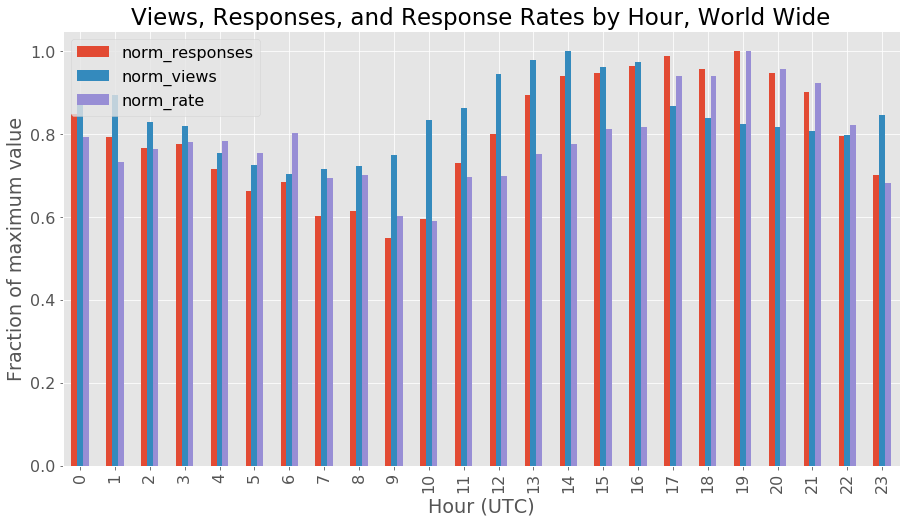

In [72]:
plt.figure()
p = worldTimes_df[['norm_responses','norm_views','norm_rate']].plot(kind='bar',title='Views, Responses, and Response Rates by Hour, World Wide')
p.set_xlabel("Hour (UTC)")
p.set_ylabel("Fraction of maximum value")

In [67]:
%%sql
SELECT country, 100.*COUNT(DISTINCT(view_id))/5865993. AS percent_views
FROM knotch
GROUP BY country
ORDER BY percent_views DESC
LIMIT 5;

Done.


country,percent_views
US,29.6914094511
CN,27.6138924816
GB,14.3434709179
BR,3.14783873762
ID,3.11154479727


In [68]:
query_US = """SELECT r.hour, r.n_responses, v.n_views
    FROM
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_responses
    FROM responses
    WHERE country == 'US'
    GROUP BY hour) r  
    JOIN
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_views
    FROM knotch
    WHERE country == 'US'
    GROUP BY hour) v
    ON r.hour = v.hour"""

query_CN = """SELECT r.hour, r.n_responses, v.n_views
    FROM
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_responses
    FROM responses
    WHERE country == 'CN'
    GROUP BY hour) r  
    JOIN
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_views
    FROM knotch
    WHERE country == 'CN'
    GROUP BY hour) v
    ON r.hour = v.hour"""

query_GB = """SELECT r.hour, r.n_responses, v.n_views
    FROM
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_responses
    FROM responses
    WHERE country == 'GB'
    GROUP BY hour) r  
    JOIN
    (SELECT strftime('%H', ts) AS hour, COUNT(view_id) AS n_views
    FROM knotch
    WHERE country == 'GB'
    GROUP BY hour) v
    ON r.hour = v.hour"""

USTimes_df = pd.read_sql(query_US, conn)
CNTimes_df = pd.read_sql(query_CN, conn)
GBTimes_df = pd.read_sql(query_GB, conn)

In [69]:
USTimes_df['responseRate'] = times_getResponseRate(USTimes_df)
CNTimes_df['responseRate'] = times_getResponseRate(CNTimes_df)
GBTimes_df['responseRate'] = times_getResponseRate(GBTimes_df)

In [70]:
USTimes_df[['norm_responses','norm_views','norm_rate']] = times_getNormColumns(USTimes_df)
CNTimes_df[['norm_responses','norm_views','norm_rate']] = times_getNormColumns(CNTimes_df)
GBTimes_df[['norm_responses','norm_views','norm_rate']] = times_getNormColumns(GBTimes_df)

In [71]:
USTimes_df['local_hour'] = times_getLocalTime(USTimes_df,-4)
CNTimes_df['local_hour'] = times_getLocalTime(CNTimes_df,8)
GBTimes_df['local_hour'] = times_getLocalTime(GBTimes_df,1)

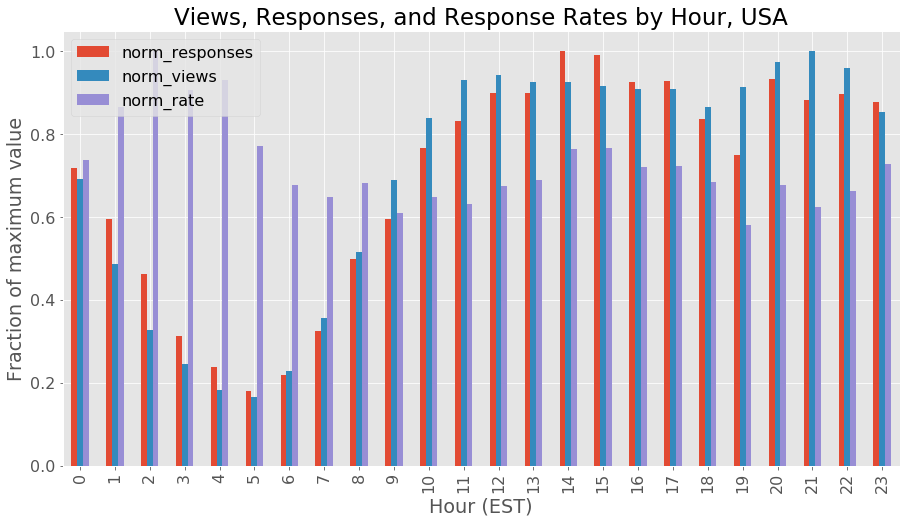

In [74]:
plt.figure();
p = USTimes_df[['local_hour','norm_responses','norm_views','norm_rate']].sort_values('local_hour').plot(x='local_hour', kind='bar', title='Views, Responses, and Response Rates by Hour, USA')
p.set_xlabel("Hour (EST)")
p.set_ylabel("Fraction of maximum value")

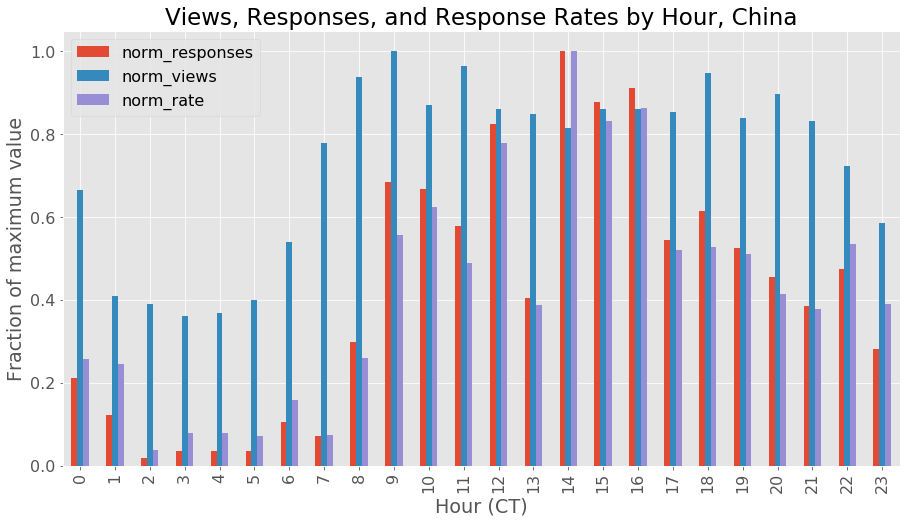

In [75]:
plt.figure();
p = CNTimes_df[['local_hour','norm_responses','norm_views','norm_rate']].sort_values('local_hour').plot(x='local_hour', kind='bar', title='Views, Responses, and Response Rates by Hour, China')
p.set_xlabel("Hour (CT)")
p.set_ylabel("Fraction of maximum value")

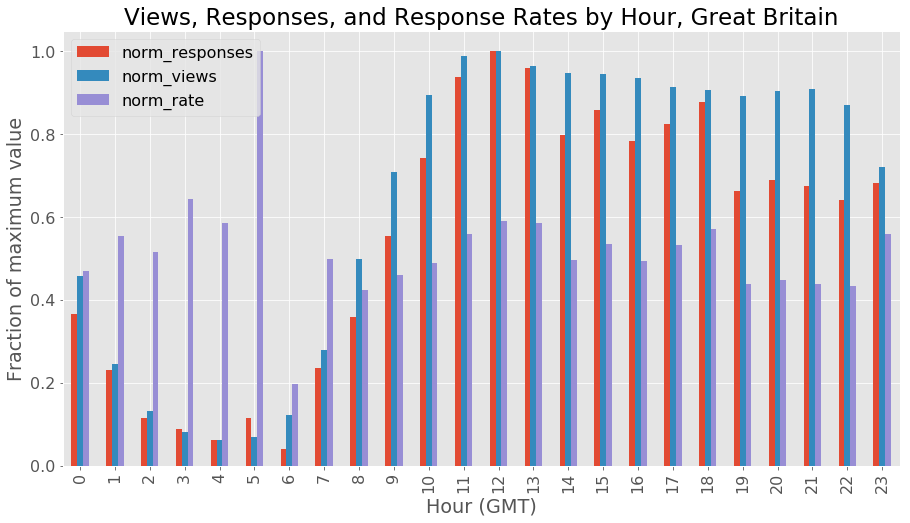

In [76]:
plt.figure();
p = GBTimes_df[['local_hour','norm_responses','norm_views','norm_rate']].sort_values('local_hour').plot(x='local_hour', kind='bar', title='Views, Responses, and Response Rates by Hour, Great Britain')
p.set_xlabel("Hour (GMT)")
p.set_ylabel("Fraction of maximum value")


In [77]:
query = """SELECT r.survey_id, r.n_responses, v.n_views, 
        CAST(r.n_responses AS float)/CAST(v.n_views AS float) AS response_rate, 
        r.avg_response, r.n_positive, r.n_negative
FROM
    (SELECT survey_id, COUNT(view_id) AS n_responses, AVG(response) AS avg_response,
         SUM(CASE WHEN response >0 THEN 1 ELSE 0 END) AS n_positive,
         SUM(CASE WHEN response <0 THEN 1 ELSE 0 END) AS n_negative
    FROM responses
    GROUP BY survey_id) r  
JOIN
    (SELECT survey_id, COUNT(view_id) AS n_views
    FROM knotch
    GROUP BY survey_id) v
ON r.survey_id = v.survey_id"""

responses_df = pd.read_sql(query, conn)

In [78]:
responses_df.sort_values('avg_response',ascending = False).head()

,survey_id,n_responses,n_views,response_rate,avg_response,n_positive,n_negative
26,5848dfdeebdaf1e45a8f26a9,7,59908,0.000117,4.428571,7,0
28,584ae842ebdaf1e45a8f92bd,1,60925,0.000016,4.000000,1,0
2,576c689af2d255082991e74f,418,131754,0.003173,3.547847,367,22
4,577acafca7fa3d7962219044,189,62065,0.003045,3.333333,154,12
27,584a87fc20c21d3a3211e20d,2,61133,0.000033,2.500000,1,0


In [79]:
def minSamp_diff(df,m,z,ps_1,ps_2):
    
    num = (z**2)/(m**2)*(ps_1*(1-ps_1)+ps_2*(1-ps_2))
    return np.ceil(num/(1.+num/df['n_views'])).astype(int)

In [80]:
responses_df['minSample_95'] = minSamp_diff(responses_df,0.05,1.960,0.5,0.5)
responses_df['minSample_90'] = minSamp_diff(responses_df,0.05,1.654,0.5,0.5)

In [81]:
responses_df[responses_df['n_responses']>=responses_df['minSample_95']].sort_values('avg_response',ascending = False)

,survey_id,n_responses,n_views,response_rate,avg_response,n_positive,n_negative,minSample_95,minSample_90
1,573b111eeb657163742cac78,1227,255734,0.004798,1.979625,814,147,767,546
9,57a84292c8b1b0a55b5d819a,1057,74147,0.014255,1.473983,668,251,761,544
23,580f8ed8bbe4ee292d370280,3346,225208,0.014857,1.243574,1673,548,766,546
0,56eb4ca59399e8047fc6592d,3850,194827,0.019761,0.562857,1966,1405,766,546


In [82]:
query = """SELECT time_on_page, time_to_interact, interaction_type, response 
FROM responses
WHERE time_to_interact IS NOT NULL AND 
    time_on_page IS NOT NULL
"""

intTimes_df = pd.read_sql(query, conn)

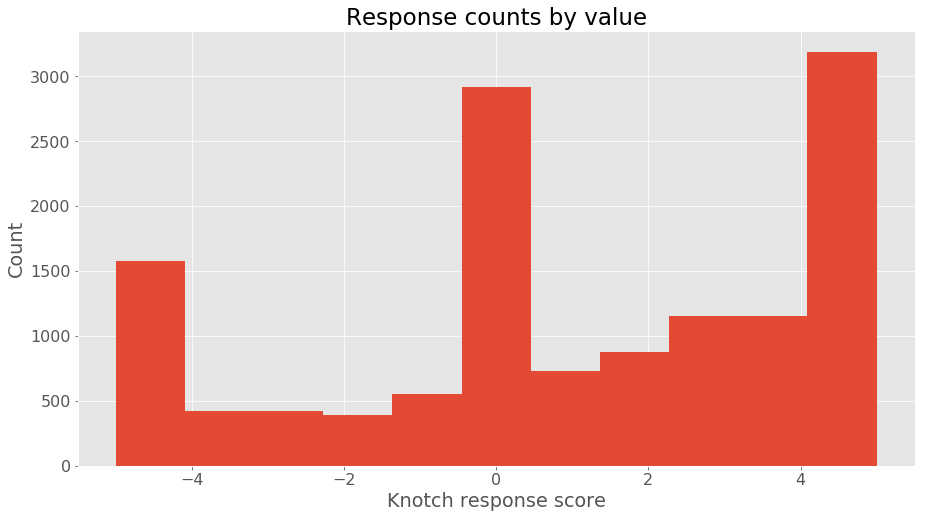

In [89]:
plt.figure()
p = intTimes_df['response'].plot.hist(bins = 11, title='Response counts by value')
p.set_xlabel("Knotch response score")
p.set_ylabel("Count")

In [83]:
def filterRange(df,col,lim):
    lb = lim[0]
    ub = lim[1]
    return df[df[col].between(lb,ub,inclusive=True)]

In [90]:
column = 'time_on_page'
quantiles = zip(np.linspace(0,0.75,4),np.linspace(0.25,1,4))
QTdfs = [filterRange(intTimes_df,column,intTimes_df[column].quantile(quant).tolist()) for quant in quantiles]

In [91]:
quart_df = pd.DataFrame()
quart_df['quart1'] = QTdfs[0]['response'].tolist()
quart_df['quart2'] = QTdfs[1]['response'].tolist()
quart_df['quart3'] = QTdfs[2]['response'].tolist()
quart_df['quart4'] = QTdfs[3]['response'].tolist()

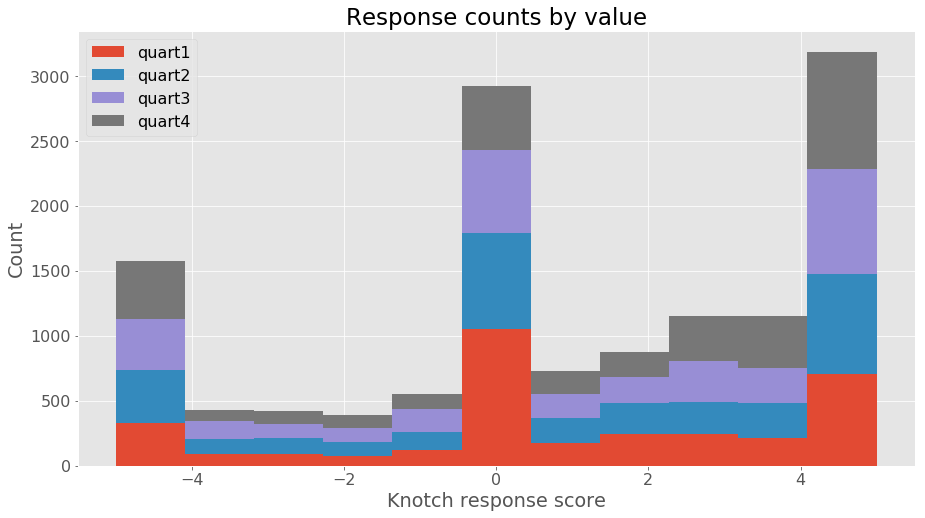

In [92]:
plt.figure()
p = quart_df.plot.hist(stacked = True,bins = 11,title='Response counts by value')
p.set_xlabel("Knotch response score")
p.set_ylabel("Count")

In [93]:
column = 'time_on_page'
quantiles = zip(np.linspace(0,0.95,20),np.linspace(0.05,1,20))
QTdfs = [filterRange(intTimes_df,column,intTimes_df[column].quantile(quant).tolist()) for quant in quantiles]

In [52]:
avg_res_no0 = [df[~df['response'].isin([0])]['response'].mean() for df in QTdfs]

In [53]:
avg_res = [df['response'].mean() for df in QTdfs]

In [99]:
n_zero = [len(df[df['response']==0])/float(len(df)) for df in QTdfs]

In [95]:
avg_time = [df['time_on_page'].mean() for df in QTdfs]

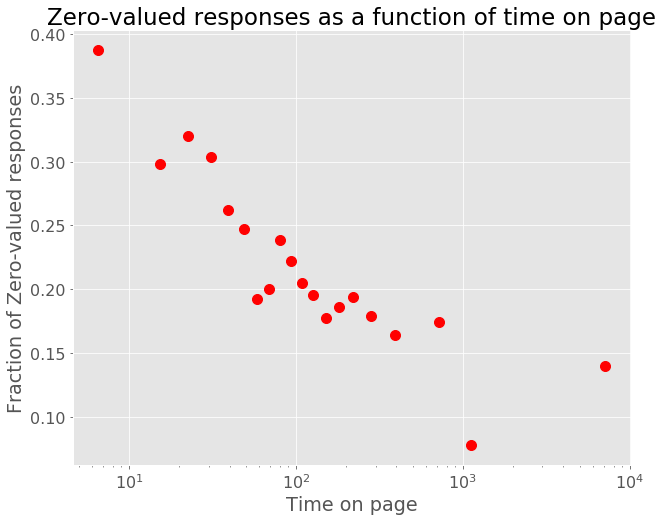

In [148]:
plt.figure(figsize = (10, 8) )
plt.plot(avg_time,n_zero,'ro',ms=10)
plt.xscale('log')
plt.xlabel('Time on page')
plt.ylabel('Fraction of Zero-valued responses')
plt.title('Zero-valued responses as a function of time on page')
plt.show()

In [118]:
query = """SELECT r.survey_id, 
        v.n_Cr_views, r.n_Cr_resp,
        v.n_IE_views, r.n_IE_resp,
        v.n_FF_views, r.n_FF_resp
FROM 
    (SELECT survey_id, 
        SUM(CASE WHEN browser == 'Chrome' THEN 1 ELSE 0 END) AS n_Cr_resp,
        SUM(CASE WHEN browser == 'IE' THEN 1 ELSE 0 END) AS n_IE_resp,
        SUM(CASE WHEN browser == 'Firefox' THEN 1 ELSE 0 END) AS n_FF_resp       
    FROM responses
    WHERE device = 'desktop'
    GROUP BY survey_id) r
JOIN
    (SELECT survey_id,
        SUM(CASE WHEN browser == 'Chrome' THEN 1 ELSE 0 END) AS n_Cr_views,
        SUM(CASE WHEN browser == 'IE' THEN 1 ELSE 0 END) AS n_IE_views,
        SUM(CASE WHEN browser == 'Firefox' THEN 1 ELSE 0 END) AS n_FF_views
    FROM knotch
    WHERE device = 'desktop'
    GROUP BY survey_id) v
ON r.survey_id = v.survey_id"""

rspByBrw_df = pd.read_sql(query, conn)

In [119]:
rspByBrw_df = rspByBrw_df.merge(responses_df, left_on='survey_id', right_on='survey_id', how='inner')

In [120]:
rspByBrw_df.drop(['minSample_90','minSample_95'],axis=1,inplace=True)

In [107]:
def minSamp_prop(df,m,z,ps_1):
    
    num = (z**2)/(m**2)*(ps_1*(1-ps_1))
    return np.ceil(num/(1.+num/df['n_views'])).astype(int)

In [108]:
rspByBrw_df['minSample_90'] = minSamp_prop(responses_df,0.1,1.654,0.5)

In [109]:
rspByBrw_df = rspByBrw_df[rspByBrw_df['n_responses']>=rspByBrw_df['minSample_90']]

In [110]:
P_Cr = 0.6924342105263158
P_IE = 0.36352657004830913
P_FF = 0.5125628140703518

In [149]:
rspByBrw_df['P_R'] = (rspByBrw_df['n_Cr_resp']+rspByBrw_df['n_IE_resp']+rspByBrw_df['n_FF_resp'])/\
                        (rspByBrw_df['n_Cr_views']+rspByBrw_df['n_IE_views']+rspByBrw_df['n_FF_views'])
rspByBrw_df['P_U'] = (rspByBrw_df['n_Cr_views']*P_Cr+rspByBrw_df['n_IE_views']*P_IE+rspByBrw_df['n_FF_views']*P_FF)/\
                        (rspByBrw_df['n_Cr_views']+rspByBrw_df['n_IE_views']+rspByBrw_df['n_FF_views'])
rspByBrw_df['P_UiR'] = (rspByBrw_df['n_Cr_resp']*P_Cr+rspByBrw_df['n_IE_resp']*P_IE+rspByBrw_df['n_FF_resp']*P_FF)/\
                        (rspByBrw_df['n_Cr_views']+rspByBrw_df['n_IE_views']+rspByBrw_df['n_FF_views'])
rspByBrw_df['P_UgR'] = rspByBrw_df['P_UiR']/rspByBrw_df['P_R']
rspByBrw_df['age18to44_represent_ratio'] = (rspByBrw_df['P_UgR']-rspByBrw_df['P_U'])/rspByBrw_df['P_U']


In [150]:
rspByBrw_df.head()

,survey_id,n_Cr_views,n_Cr_resp,n_IE_views,n_IE_resp,n_FF_views,n_FF_resp,n_responses,n_views,response_rate,avg_response,n_positive,n_negative,P_R,P_U,P_UiR,P_UgR,age18to44_represent_ratio
0,56eb4ca59399e8047fc6592d,18344,1100,1211,30,4652,1454,3850,194827,0.019761,0.562857,1966,1405,0.106746,0.641413,0.062703,0.587403,-0.084205
1,573b111eeb657163742cac78,26991,416,15040,28,4686,67,1227,255734,0.004798,1.979625,814,147,0.010938,0.568504,0.007119,0.650828,0.144808
2,576c689af2d255082991e74f,80226,284,829,4,9721,63,418,131754,0.003173,3.547847,367,22,0.003867,0.670168,0.002538,0.656401,-0.020543
3,577a4a113b54999e73e78d80,83392,59,105865,61,3754,4,159,473923,0.000335,1.308176,67,17,0.000642,0.508533,0.000337,0.524831,0.032049
4,577acafca7fa3d7962219044,27659,117,2598,1,4756,21,189,62065,0.003045,3.333333,154,12,0.003970,0.643596,0.002632,0.662893,0.029983


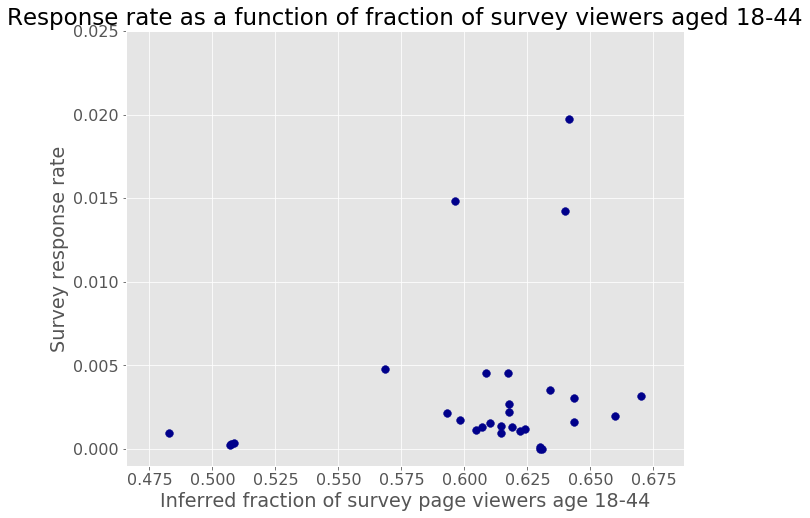

In [143]:
plt.figure(figsize = (10, 8))
p = rspByBrw_df.plot.scatter(x = 'P_U', y = 'response_rate', 
                        title = 'Response rate as a function of fraction of survey viewers aged 18-44',
                        ylim=(-0.001, 0.025), color='DarkBlue', s = 60, figsize = (10, 8))
p.set_xlabel("Inferred fraction of survey page viewers age 18-44")
p.set_ylabel("Survey response rate")

In [155]:
def minSamp_prop(df,m,z,ps_1):
    
    num = (z**2)/(m**2)*(ps_1*(1-ps_1))
    return np.ceil(num/(1.+num/df['n_views'])).astype(int)

In [158]:
rspByBrw_df['minSample_90'] = minSamp_prop(responses_df,0.05,1.654,0.5)

In [172]:
rspByBrw_fltrd_df = rspByBrw_df[rspByBrw_df['n_responses']>=rspByBrw_df['minSample_90']]

In [173]:
rspByBrw_fltrd_df = rspByBrw_fltrd_df.set_index('survey_id')

In [174]:
rspByBrw_fltrd_df['age18to44_represent_ratio'].mean()

0.03838429522051888

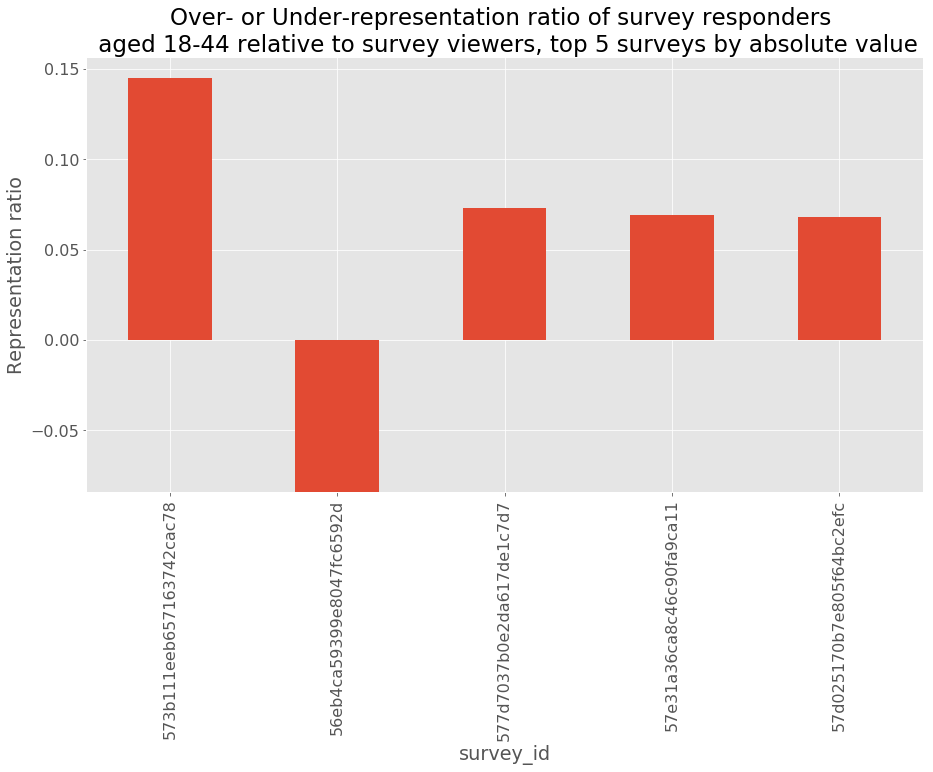

In [175]:
barPlot_df = rspByBrw_fltrd_df.reindex(rspByBrw_fltrd_df['age18to44_represent_ratio'].abs().sort_values(ascending=False).index)['age18to44_represent_ratio'].head()
plt.figure();
p = barPlot_df.plot(kind='bar',title='Over- or Under-representation ratio of survey responders \n aged 18-44 relative to survey viewers, top 5 surveys by absolute value')
p.set_ylabel("Representation ratio")

In [183]:
query = """SELECT survey_id, 
    SUM(CASE WHEN browser == 'Chrome' THEN 1 ELSE 0 END) AS n_Cr_resp,
    SUM(CASE WHEN browser == 'Chrome' AND response >0 THEN 1 ELSE 0 END) AS n_Cr_pos,
    SUM(CASE WHEN browser == 'Firefox' THEN 1 ELSE 0 END) AS n_FF_resp,
    SUM(CASE WHEN browser == 'Firefox' AND response >0 THEN 1 ELSE 0 END) AS n_FF_pos,
    SUM(CASE WHEN browser == 'IE' THEN 1 ELSE 0 END) AS n_IE_resp,
    SUM(CASE WHEN browser == 'IE' AND response >0 THEN 1 ELSE 0 END) AS n_IE_pos
FROM responses
WHERE device = 'desktop'
GROUP BY survey_id"""

posByBrw_df = pd.read_sql(query, conn)

In [184]:
posByBrw_df = posByBrw_df.merge(responses_df, left_on='survey_id', right_on='survey_id', how='inner')

In [185]:
posByBrw_df['P_UiL'] = (posByBrw_df['n_Cr_pos']*P_Cr+posByBrw_df['n_FF_pos']*P_FF+posByBrw_df['n_IE_pos']*P_IE)/\
                        (posByBrw_df['n_Cr_resp']+posByBrw_df['n_FF_resp']+posByBrw_df['n_IE_resp'])
posByBrw_df['P_U'] = (posByBrw_df['n_Cr_resp']*P_Cr+posByBrw_df['n_FF_resp']*P_FF+posByBrw_df['n_IE_resp']*P_IE)/\
                        (posByBrw_df['n_Cr_resp']+posByBrw_df['n_FF_resp']+posByBrw_df['n_IE_resp'])
posByBrw_df['P_LgU'] = posByBrw_df['P_UiL']/posByBrw_df['P_U']
posByBrw_df['P_L'] = (posByBrw_df['n_Cr_pos']+posByBrw_df['n_FF_pos']+posByBrw_df['n_IE_pos'])/\
                        (posByBrw_df['n_Cr_resp']+posByBrw_df['n_FF_resp']+posByBrw_df['n_IE_resp'])
posByBrw_df['P_UgL'] = posByBrw_df['P_UiL']/posByBrw_df['P_L']
posByBrw_df['age18to44_represent_ratio'] = (posByBrw_df['P_LgU']-posByBrw_df['P_L'])/posByBrw_df['P_L']

In [191]:
posByBrw_df['minSample_90'] = minSamp_prop(posByBrw_df,0.05,1.654,0.5)
posByBrw_fltrd_df = posByBrw_df[posByBrw_df['n_responses']>=posByBrw_df['minSample_90']]
posByBrw_fltrd_df = posByBrw_fltrd_df.set_index('survey_id')

In [193]:
posByBrw_fltrd_df['age18to44_represent_ratio'].mean()

0.013436475750750418

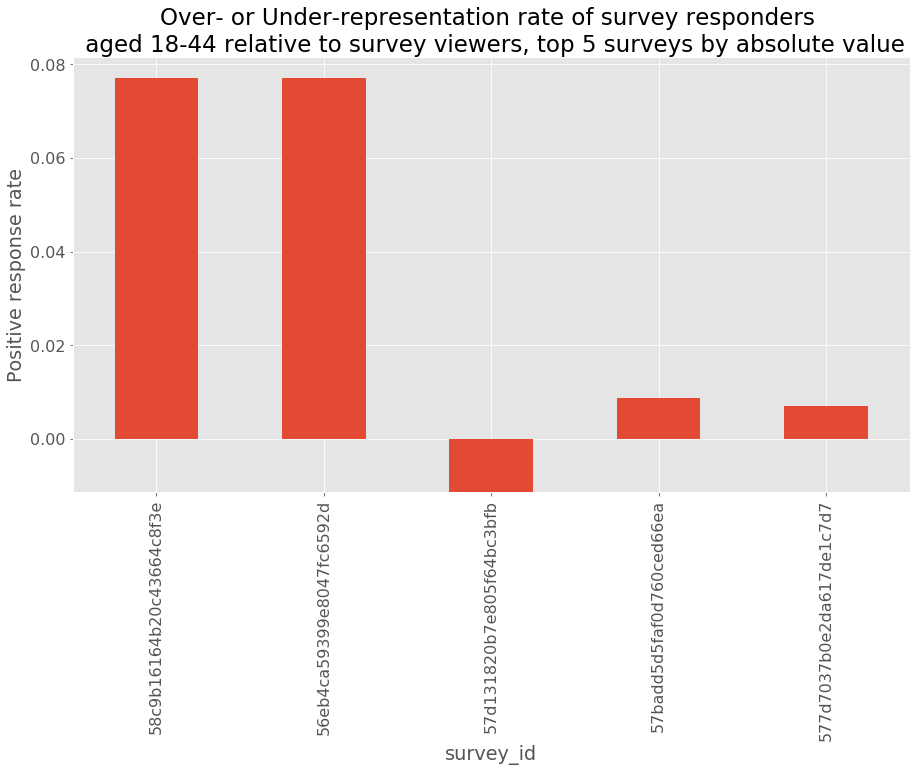

In [194]:
barPlot_df = posByBrw_fltrd_df.reindex(posByBrw_fltrd_df['age18to44_represent_ratio'].abs().sort_values(ascending=False).index)['age18to44_represent_ratio'].head()
plt.figure();
p = barPlot_df.plot(kind='bar',title='Over- or Under-representation rate of survey responders \n aged 18-44 relative to survey viewers, top 5 surveys by absolute value')
p.set_ylabel("Positive response rate")

In [197]:
%%sql
SELECT country, 100.*COUNT(DISTINCT(view_id))/(SELECT COUNT(view_id) FROM knotch) AS percent_views,
    100.*SUM(CASE WHEN response IS NOT NULL THEN 1 ELSE 0 END)/(SELECT COUNT(view_id) FROM responses) AS percent_responses
FROM knotch
GROUP BY country
ORDER BY percent_views DESC
LIMIT 10;

Done.


country,percent_views,percent_responses
US,29.6914296975,52.0096560048
CN,27.6139113115,3.49426674713
GB,14.3434806987,11.8768859384
BR,3.14784088412,4.05552202776
ID,3.11154691903,0.156910078455
CA,2.77934377306,4.68316234158
FR,2.54512921862,1.33373566687
VN,2.33336612121,1.70187085094
ES,1.78653591065,1.69583584792
AU,1.73764389943,1.40615570308


In [265]:
query_os = """SELECT os AS feature, 'os' AS feature_type, COUNT(view_id) AS n_views_WW, 
    SUM(CASE WHEN response IS NOT NULL THEN 1 ELSE 0 END) AS n_responses_WW,
    SUM(CASE WHEN country = 'CN' THEN 1 ELSE 0 END) AS n_views_CN,
    SUM(CASE WHEN country = 'CN' AND response IS NOT NULL THEN 1 ELSE 0 END) AS n_responses_CN
FROM knotch
GROUP BY os
ORDER BY n_views_WW DESC
LIMIT 4;"""

query_dev = """SELECT device AS feature, 'device' AS feature_type, COUNT(view_id) AS n_views_WW, 
    SUM(CASE WHEN response IS NOT NULL THEN 1 ELSE 0 END) AS n_responses_WW,
    SUM(CASE WHEN country = 'CN' THEN 1 ELSE 0 END) AS n_views_CN,
    SUM(CASE WHEN country = 'CN' AND response IS NOT NULL THEN 1 ELSE 0 END) AS n_responses_CN
FROM knotch
GROUP BY device
ORDER BY n_views_WW DESC
LIMIT 3;"""

query_brw = """SELECT browser AS feature, 'browser' AS feature_type, COUNT(view_id) AS n_views_WW, 
    SUM(CASE WHEN response IS NOT NULL THEN 1 ELSE 0 END) AS n_responses_WW,
    SUM(CASE WHEN country = 'CN' THEN 1 ELSE 0 END) AS n_views_CN,
    SUM(CASE WHEN country = 'CN' AND response IS NOT NULL THEN 1 ELSE 0 END) AS n_responses_CN
FROM knotch
GROUP BY browser
ORDER BY n_views_WW DESC
LIMIT 10;"""

os_df = pd.read_sql(query_os, conn)
dev_df = pd.read_sql(query_dev, conn)
brw_df = pd.read_sql(query_brw, conn)

In [368]:
WWvsCN_df = pd.concat([os_df,dev_df,brw_df])
WWvsCN_df['rate_WW'] = WWvsCN_df['n_responses_WW']/WWvsCN_df['n_views_WW']
WWvsCN_df['rate_CN'] = WWvsCN_df['n_responses_CN']/WWvsCN_df['n_views_CN']

In [369]:
WWvsCN_df = WWvsCN_df[WWvsCN_df['rate_CN']!=0]
WWvsCN_df = WWvsCN_df.reset_index()

In [370]:
def func(df):
    df['weighted_rate_WW'] = df['rate_WW']*(df['n_views_WW']/df['n_views_WW'].sum())
    df['weighted_rate_CN'] = df['rate_CN']*(df['n_views_CN']/df['n_views_CN'].sum())
    return df

WWvsCN_df = WWvsCN_df.groupby('feature_type').apply(func) 
WWvsCN_df['weighted_rate_ratio'] = WWvsCN_df['weighted_rate_WW']/WWvsCN_df['weighted_rate_CN']
WWvsCN_df.drop('index', axis = 1, inplace = True)
WWvsCN_df = WWvsCN_df.set_index('feature')

In [371]:
WWvsCN_df.groupby('feature_type').get_group('os').sort_values('weighted_rate_ratio',ascending = False).head()['weighted_rate_ratio']

feature
Mac OS     72.341798
iOS        23.291342
Android    15.979026
Windows     4.785205
Name: weighted_rate_ratio, dtype: float64

In [372]:
WWvsCN_df.groupby('feature_type').get_group('device').sort_values('weighted_rate_ratio',ascending = False).head()['weighted_rate_ratio']

feature
tablet     254.347140
mobile      14.023464
desktop      6.290215
Name: weighted_rate_ratio, dtype: float64

In [373]:
WWvsCN_df.groupby('feature_type').get_group('browser').sort_values('weighted_rate_ratio',ascending = False).head(10)['weighted_rate_ratio']

feature
Safari             73.851614
Firefox            44.291414
Android Browser    18.893107
Chrome              9.654475
Edge                6.737384
WebKit              2.560736
IE                  1.267667
Name: weighted_rate_ratio, dtype: float64